In [1]:
# ## 1. Load and Preprocess Burglary Data

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data and aggregate to ward-monthly counts
burglary = pd.read_csv('data/residential_burglary.csv')

# Combine 'Year' and 'Month' into a single datetime column
burglary ["Month"] = pd.to_datetime(burglary ["Year"].astype(str) + "-" + burglary ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

print("Raw data overview:")
print(f"Total wards: {burglary_monthly['Ward Code'].nunique()}")
print(f"Time range: {burglary_monthly['Month'].min()} to {burglary_monthly['Month'].max()}")


Raw data overview:
Total wards: 679
Time range: 2013-12-01 00:00:00 to 2025-02-01 00:00:00


In [3]:
# ## 2. SARIMA Forecasting for All Wards

import warnings

warnings.filterwarnings("ignore")

# Set manual orders for all wards
UNIVERSAL_ORDER = (3, 1, 1)
SEASONAL_ORDER = (3, 1, 1, 12)  # Monthly seasonality
TEST_MONTHS = 26

def analyze_ward(args):
    """Process a single ward with SARIMAX"""
    ward_code, ward_df = args
    try:
        # Prepare dataframe
        ward_df = ward_df[['Month', 'Count']].set_index('Month').asfreq('MS')

        if ward_df.isnull().values.any():
            print(f"{ward_code} has NaN values")
            if ward_df.isnull().sum().sum() > 10:
                print(f"{ward_code} has more than 10 NaN values, aborted")
                return None
            ward_df.ffill(inplace=True)

        # Filter wards with sufficient history
        if len(ward_df) < TEST_MONTHS * 2:
            print(f"{ward_code} has insufficient data")
            print(ward_df)
            return None

        # Split data
        train = ward_df.iloc[:-TEST_MONTHS]
        test = ward_df.iloc[-TEST_MONTHS:]

        # Fit SARIMAX model
        model = SARIMAX(train,
                       order=UNIVERSAL_ORDER,
                       seasonal_order=SEASONAL_ORDER,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        results = model.fit(disp=False)

        # Generate predictions
        preds = results.get_forecast(steps=TEST_MONTHS).predicted_mean

        # Calculate residuals
        residuals = test['Count'].values - preds.values

        print(f"{ward_code} completed")
        return {
            'ward_code': ward_code,
            'train_size': len(train),
            'test_size': len(test),
            'residuals': residuals,
            'predicted': preds.values,
            'actual': test['Count'].values,
            'model_summary': results.summary()
        }
    except Exception as e:
        print(f"Error processing {ward_code}: {str(e)}")
        return None

# # Prepare arguments for multiprocessing
# args_list = [(code, group.copy())
#             for code, group in burglary_monthly.groupby('Ward Code')]
#
# # Process wards in parallel
# with mp.Pool(processes=mp.cpu_count()) as pool:
#     results = pool.map(analyze_ward, args_list)
#
# # Filter successful results
# results = [res for res in results if res is not None]
# print(f"\nSuccessfully processed {len(results)} wards")

# Process all wards
results = []
# i = 0
for ward_code, group in burglary_monthly.groupby('Ward Code'):
    analysis = analyze_ward((ward_code, group))
    if analysis:
        results.append(analysis)
    #     i += 1
    # if i > 3:
    #     break   # just to test a few wards, not all

# Remove None results
results = [res for res in results if res is not None]

print(f"\nSuccessfully processed {len(results)} wards with sufficient data")

warnings.filterwarnings("default")

E05009317 completed
E05009318 completed
E05009319 completed
E05009320 completed
E05009321 has NaN values
E05009321 completed
E05009322 completed
E05009323 completed
E05009324 has NaN values
E05009324 completed
E05009325 completed
E05009326 has NaN values
E05009326 has more than 10 NaN values, aborted
E05009327 completed
E05009328 has NaN values
E05009328 has more than 10 NaN values, aborted
E05009329 completed
E05009330 completed
E05009331 completed
E05009332 completed
E05009333 completed
E05009334 completed
E05009335 completed
E05009336 completed
E05009367 has NaN values
E05009367 completed
E05009368 has NaN values
E05009368 completed
E05009369 completed
E05009370 completed
E05009371 completed
E05009372 completed
E05009373 completed
E05009374 completed
E05009375 completed
E05009376 completed
E05009377 completed
E05009378 completed
E05009379 completed
E05009380 completed
E05009381 completed
E05009382 completed
E05009383 completed
E05009384 has NaN values
E05009384 completed
E05009385 c

In [4]:
# Load and process car ownership data
cars_df = pd.read_excel('data/housing/cars_or_vans_wards.xlsx', sheet_name='2021')
cars_df['NoCarPct'] = (cars_df['none'] / cars_df['All households'])
cars = cars_df[['ward code', 'NoCarPct']].rename(columns={'ward code': 'ward_code'})

# Merge with SARIMA results
results_df = pd.DataFrame(results)

hybrid_data = pd.merge(results_df, cars, on='ward_code', how='inner')

occupancy_df = pd.read_excel('data/housing/occupancy_rating_bedrooms_wards.xlsx', sheet_name='2021')
occupancy_df["ZeroRoomPct"] = (occupancy_df["0"] / occupancy_df["All Households"])
occupancy = occupancy_df[["ward code", "ZeroRoomPct"]].rename(columns={'ward code': 'ward_code'})

results_df = pd.DataFrame(occupancy)

hybrid_data = pd.merge(hybrid_data, occupancy, on='ward_code', how='inner')


print(f"Wards with both SARIMA and socio-economic data: {len(hybrid_data)}")

hybrid_data

Wards with both SARIMA and socio-economic data: 631


,ward_code,train_size,test_size,residuals,predicted,actual,model_summary,NoCarPct,ZeroRoomPct
0,E05009317,109,26,"[14.115730573276426, 2.692705646825771, 6.8469...","[11.884269426723574, 7.307294353174229, 15.153...","[26, 10, 22, 17, 21, 13, 11, 13, 13, 14, 17, 7...",SARIMAX R...,0.632145,0.484684
1,E05009318,109,26,"[-5.771026978346503, -3.4090767869296066, -3.3...","[9.771026978346503, 7.409076786929607, 11.3074...","[4, 4, 8, 4, 13, 6, 9, 13, 5, 8, 6, 10, 9, 1, ...",SARIMAX R...,0.691681,0.577126
2,E05009319,109,26,"[15.993722886860732, 9.14743671657375, 15.8926...","[10.006277113139268, 2.8525632834262487, 7.107...","[26, 12, 23, 13, 10, 12, 21, 19, 7, 16, 16, 17...",SARIMAX R...,0.650541,0.540274
3,E05009320,109,26,"[9.138701972669303, 4.097603664031639, 2.54576...","[3.8612980273306965, 4.902396335968361, 8.4542...","[13, 9, 11, 15, 1, 2, 10, 3, 12, 12, 6, 7, 15,...",SARIMAX R...,0.577921,0.444402
4,E05009321,109,26,"[1.715359611303068, 10.814270333694708, 4.9362...","[6.284640388696932, 2.185729666305291, 4.06375...","[8.0, 13.0, 9.0, 3.0, 5.0, 9.0, 6.0, 6.0, 8.0,...",SARIMAX R...,0.640424,0.532069
...,...,...,...,...,...,...,...,...,...
626,E05014115,109,26,"[0.8691822946425303, 5.3076393093977146, 13.97...","[7.13081770535747, 5.6923606906022854, 6.02819...","[8, 11, 20, 9, 9, 8, 14, 10, 16, 7, 6, 7, 7, 9...",SARIMAX R...,0.525633,0.447277
627,E05014116,109,26,"[-3.5033093977403578, -0.4327309013461291, 0.7...","[4.503309397740358, 2.432730901346129, 3.25992...","[1.0, 2.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 2.0, ...",SARIMAX R...,0.497338,0.424015
628,E05014117,109,26,"[-3.578239138331659, -0.8701161592198945, 1.03...","[6.578239138331659, 2.8701161592198945, 3.9600...","[3.0, 2.0, 5.0, 2.0, 3.0, 8.0, 6.0, 5.0, 12.0,...",SARIMAX R...,0.747097,0.562408
629,E05014118,109,26,"[0.7893046474880308, 4.503184579028071, 7.6380...","[9.21069535251197, 5.496815420971929, 5.361915...","[10, 10, 13, 11, 9, 9, 8, 8, 9, 5, 5, 6, 7, 12...",SARIMAX R...,0.726968,0.547262


Correlation between NoCarPct and mean_residuals:
  Pearson:  r = -0.092 (p-value = 0.021)
  Spearman: r = -0.117 (p-value = 0.003)
  Kendall:  r = -0.081 (p-value = 0.002)

Correlation between NoCarPct and abs_mean_residuals:
  Pearson:  r = 0.352 (p-value = 0.000)
  Spearman: r = 0.335 (p-value = 0.000)
  Kendall:  r = 0.231 (p-value = 0.000)

Correlation between ZeroRoomPct and mean_residuals:
  Pearson:  r = -0.128 (p-value = 0.001)
  Spearman: r = -0.153 (p-value = 0.000)
  Kendall:  r = -0.105 (p-value = 0.000)

Correlation between ZeroRoomPct and abs_mean_residuals:
  Pearson:  r = 0.314 (p-value = 0.000)
  Spearman: r = 0.314 (p-value = 0.000)
  Kendall:  r = 0.215 (p-value = 0.000)



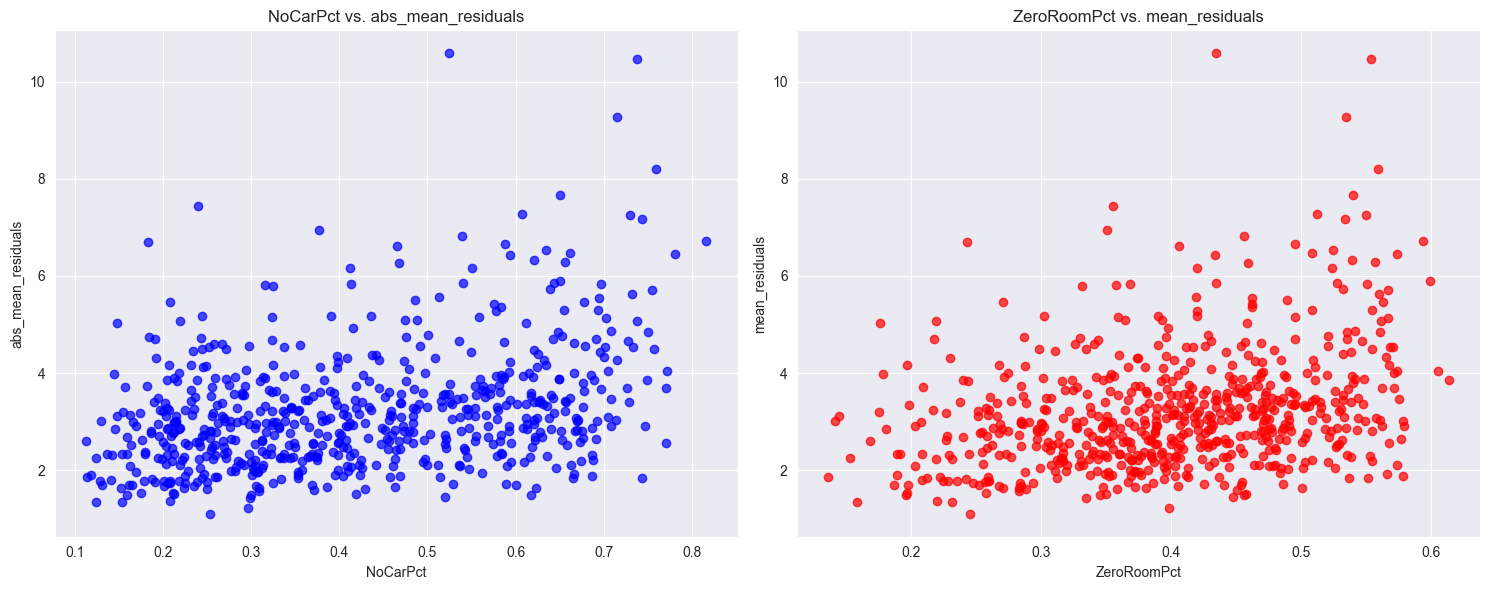

In [7]:
from scipy.stats import pearsonr, spearmanr, kendalltau


# Calculate mean and absolute mean residuals for each ward
mean_residuals = hybrid_data["residuals"].apply(np.mean)
abs_mean_residuals = hybrid_data["residuals"].apply(lambda x: np.mean(np.abs(x)))

# Extract socio-economic percentage columns
no_car_pct = hybrid_data["NoCarPct"]
zero_room_pct = hybrid_data["ZeroRoomPct"]

# Calculate correlations between NoCarPct and the residual metrics
p_no_mean = pearsonr(no_car_pct, mean_residuals)
s_no_mean = spearmanr(no_car_pct, mean_residuals)
k_no_mean = kendalltau(no_car_pct, mean_residuals)

p_no_abs = pearsonr(no_car_pct, abs_mean_residuals)
s_no_abs = spearmanr(no_car_pct, abs_mean_residuals)
k_no_abs = kendalltau(no_car_pct, abs_mean_residuals)

# Print formatted correlations for NoCarPct relationships
print("Correlation between NoCarPct and mean_residuals:")
print(f"  Pearson:  r = {p_no_mean[0]:.3f} (p-value = {p_no_mean[1]:.3f})")
print(f"  Spearman: r = {s_no_mean[0]:.3f} (p-value = {s_no_mean[1]:.3f})")
print(f"  Kendall:  r = {k_no_mean[0]:.3f} (p-value = {k_no_mean[1]:.3f})\n")

print("Correlation between NoCarPct and abs_mean_residuals:")
print(f"  Pearson:  r = {p_no_abs[0]:.3f} (p-value = {p_no_abs[1]:.3f})")
print(f"  Spearman: r = {s_no_abs[0]:.3f} (p-value = {s_no_abs[1]:.3f})")
print(f"  Kendall:  r = {k_no_abs[0]:.3f} (p-value = {k_no_abs[1]:.3f})\n")

# Calculate correlations between ZeroRoomPct and the residual metrics
p_zero_mean = pearsonr(zero_room_pct, mean_residuals)
s_zero_mean = spearmanr(zero_room_pct, mean_residuals)
k_zero_mean = kendalltau(zero_room_pct, mean_residuals)

p_zero_abs = pearsonr(zero_room_pct, abs_mean_residuals)
s_zero_abs = spearmanr(zero_room_pct, abs_mean_residuals)
k_zero_abs = kendalltau(zero_room_pct, abs_mean_residuals)

# Print formatted correlations for ZeroRoomPct relationships
print("Correlation between ZeroRoomPct and mean_residuals:")
print(f"  Pearson:  r = {p_zero_mean[0]:.3f} (p-value = {p_zero_mean[1]:.3f})")
print(f"  Spearman: r = {s_zero_mean[0]:.3f} (p-value = {s_zero_mean[1]:.3f})")
print(f"  Kendall:  r = {k_zero_mean[0]:.3f} (p-value = {k_zero_mean[1]:.3f})\n")

print("Correlation between ZeroRoomPct and abs_mean_residuals:")
print(f"  Pearson:  r = {p_zero_abs[0]:.3f} (p-value = {p_zero_abs[1]:.3f})")
print(f"  Spearman: r = {s_zero_abs[0]:.3f} (p-value = {s_zero_abs[1]:.3f})")
print(f"  Kendall:  r = {k_zero_abs[0]:.3f} (p-value = {k_zero_abs[1]:.3f})\n")

# Plotting the scatter plots in a single figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for NoCarPct vs. abs_mean_residuals
ax[0].scatter(no_car_pct, abs_mean_residuals, c='blue', alpha=0.7)
ax[0].set_xlabel("NoCarPct")
ax[0].set_ylabel("abs_mean_residuals")
ax[0].set_title("NoCarPct vs. abs_mean_residuals")

# Scatter plot for ZeroRoomPct vs. mean_residuals
ax[1].scatter(zero_room_pct, abs_mean_residuals, c='red', alpha=0.7)
ax[1].set_xlabel("ZeroRoomPct")
ax[1].set_ylabel("mean_residuals")
ax[1].set_title("ZeroRoomPct vs. mean_residuals")

plt.tight_layout()
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression

# Compute ward-level metrics
hybrid_data['mean_residual'] = hybrid_data['residuals'].apply(np.mean)
hybrid_data['mae'] = hybrid_data['residuals'].apply(lambda x: np.mean(np.abs(x)))
hybrid_data['overpredict_pct'] = hybrid_data['residuals'].apply(
    lambda x: np.mean(np.array(x) < 0) * 100  # Percentage of negative residuals
)

# Prepare feature matrix (socio-economic factors)
X = hybrid_data[['NoCarPct', 'ZeroRoomPct']]

# 1. Train linear models
# Model for mean residual
residual_model = LinearRegression()
residual_model.fit(X, hybrid_data['mean_residual'])

# Model for MAE
mae_model = LinearRegression()
mae_model.fit(X, hybrid_data['mae'])

# Add predictions to dataframe
hybrid_data['predicted_residual'] = residual_model.predict(X)
hybrid_data['predicted_mae'] = mae_model.predict(X)

hybrid_data

,ward_code,train_size,test_size,residuals,predicted,actual,model_summary,NoCarPct,ZeroRoomPct,mean_residual,mae,overpredict_pct,predicted_residual,predicted_mae
0,E05009317,109,26,"[14.115730573276426, 2.692705646825771, 6.8469...","[11.884269426723574, 7.307294353174229, 15.153...","[26, 10, 22, 17, 21, 13, 11, 13, 13, 14, 17, 7...",SARIMAX R...,0.632145,0.484684,1.127617,4.266213,42.307692,0.498275,3.780058
1,E05009318,109,26,"[-5.771026978346503, -3.4090767869296066, -3.3...","[9.771026978346503, 7.409076786929607, 11.3074...","[4, 4, 8, 4, 13, 6, 9, 13, 5, 8, 6, 10, 9, 1, ...",SARIMAX R...,0.691681,0.577126,-1.270601,2.642042,65.384615,0.088118,3.915976
2,E05009319,109,26,"[15.993722886860732, 9.14743671657375, 15.8926...","[10.006277113139268, 2.8525632834262487, 7.107...","[26, 12, 23, 13, 10, 12, 21, 19, 7, 16, 16, 17...",SARIMAX R...,0.650541,0.540274,6.923223,7.656145,7.692308,0.221752,3.814582
3,E05009320,109,26,"[9.138701972669303, 4.097603664031639, 2.54576...","[3.8612980273306965, 4.902396335968361, 8.4542...","[13, 9, 11, 15, 1, 2, 10, 3, 12, 12, 6, 7, 15,...",SARIMAX R...,0.577921,0.444402,3.034467,3.943257,19.230769,0.628460,3.644128
4,E05009321,109,26,"[1.715359611303068, 10.814270333694708, 4.9362...","[6.284640388696932, 2.185729666305291, 4.06375...","[8.0, 13.0, 9.0, 3.0, 5.0, 9.0, 6.0, 6.0, 8.0,...",SARIMAX R...,0.640424,0.532069,2.116701,3.538185,38.461538,0.249863,3.789412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,E05014115,109,26,"[0.8691822946425303, 5.3076393093977146, 13.97...","[7.13081770535747, 5.6923606906022854, 6.02819...","[8, 11, 20, 9, 9, 8, 14, 10, 16, 7, 6, 7, 7, 9...",SARIMAX R...,0.525633,0.447277,1.022094,3.766235,38.461538,0.522779,3.501516
627,E05014116,109,26,"[-3.5033093977403578, -0.4327309013461291, 0.7...","[4.503309397740358, 2.432730901346129, 3.25992...","[1.0, 2.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 2.0, ...",SARIMAX R...,0.497338,0.424015,1.486565,2.227110,30.769231,0.603137,3.431203
628,E05014117,109,26,"[-3.578239138331659, -0.8701161592198945, 1.03...","[6.578239138331659, 2.8701161592198945, 3.9600...","[3.0, 2.0, 5.0, 2.0, 3.0, 8.0, 6.0, 5.0, 12.0,...",SARIMAX R...,0.747097,0.562408,1.694867,2.904172,34.615385,0.264810,4.070348
629,E05014118,109,26,"[0.7893046474880308, 4.503184579028071, 7.6380...","[9.21069535251197, 5.496815420971929, 5.361915...","[10, 10, 13, 11, 9, 9, 8, 8, 9, 5, 5, 6, 7, 12...",SARIMAX R...,0.726968,0.547262,3.659834,4.654284,15.384615,0.314200,4.019939


In [21]:
# 2. Create adjusted predictions
def adjust_predictions(row):
    actual = row['actual']
    predicted = row['predicted']
    residuals = row['residuals']
    n = len(predicted)

    # Mean residual adjustment (simple addition)
    adj_res = predicted + row['predicted_residual']

    # MAE adjustment with sign determination
    if row['overpredict_pct'] > 50:  # Majority overprediction -> subtract
        adj_mae = predicted - row['predicted_mae']
    else:  # Majority underpredicton -> add
        adj_mae = predicted + row['predicted_mae']

    return adj_res, adj_mae

# Apply adjustments
adj_results = hybrid_data.apply(adjust_predictions, axis=1, result_type='expand')

hybrid_data['adj_res_pred'], hybrid_data['adj_mae_pred'] = zip(*adj_results.values)

hybrid_data

<class 'pandas.core.frame.DataFrame'>


,ward_code,train_size,test_size,residuals,predicted,actual,model_summary,NoCarPct,ZeroRoomPct,mean_residual,mae,overpredict_pct,predicted_residual,predicted_mae,adj_res_pred,adj_mae_pred
0,E05009317,109,26,"[14.115730573276426, 2.692705646825771, 6.8469...","[11.884269426723574, 7.307294353174229, 15.153...","[26, 10, 22, 17, 21, 13, 11, 13, 13, 14, 17, 7...",SARIMAX R...,0.632145,0.484684,1.127617,4.266213,42.307692,0.498275,3.780058,"[12.382544298051316, 7.805569224501971, 15.651...","[15.664327835168299, 11.087352761618956, 18.93..."
1,E05009318,109,26,"[-5.771026978346503, -3.4090767869296066, -3.3...","[9.771026978346503, 7.409076786929607, 11.3074...","[4, 4, 8, 4, 13, 6, 9, 13, 5, 8, 6, 10, 9, 1, ...",SARIMAX R...,0.691681,0.577126,-1.270601,2.642042,65.384615,0.088118,3.915976,"[9.859145312767414, 7.497195121350517, 11.3955...","[5.855051138314437, 3.49310094689754, 7.391494..."
2,E05009319,109,26,"[15.993722886860732, 9.14743671657375, 15.8926...","[10.006277113139268, 2.8525632834262487, 7.107...","[26, 12, 23, 13, 10, 12, 21, 19, 7, 16, 16, 17...",SARIMAX R...,0.650541,0.540274,6.923223,7.656145,7.692308,0.221752,3.814582,"[10.228029194183247, 3.0743153644702277, 7.329...","[13.82085952195936, 6.667145692246341, 10.9219..."
3,E05009320,109,26,"[9.138701972669303, 4.097603664031639, 2.54576...","[3.8612980273306965, 4.902396335968361, 8.4542...","[13, 9, 11, 15, 1, 2, 10, 3, 12, 12, 6, 7, 15,...",SARIMAX R...,0.577921,0.444402,3.034467,3.943257,19.230769,0.628460,3.644128,"[4.4897583066521625, 5.530856615289827, 9.0826...","[7.505425576607486, 8.54652388524515, 12.09835..."
4,E05009321,109,26,"[1.715359611303068, 10.814270333694708, 4.9362...","[6.284640388696932, 2.185729666305291, 4.06375...","[8.0, 13.0, 9.0, 3.0, 5.0, 9.0, 6.0, 6.0, 8.0,...",SARIMAX R...,0.640424,0.532069,2.116701,3.538185,38.461538,0.249863,3.789412,"[6.534503013450774, 2.4355922910591334, 4.3136...","[10.0740523851974, 5.9751416628057585, 7.85317..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,E05014115,109,26,"[0.8691822946425303, 5.3076393093977146, 13.97...","[7.13081770535747, 5.6923606906022854, 6.02819...","[8, 11, 20, 9, 9, 8, 14, 10, 16, 7, 6, 7, 7, 9...",SARIMAX R...,0.525633,0.447277,1.022094,3.766235,38.461538,0.522779,3.501516,"[7.653597134192057, 6.215140119436873, 6.55097...","[10.632333526536382, 9.193876511781196, 9.5297..."
627,E05014116,109,26,"[-3.5033093977403578, -0.4327309013461291, 0.7...","[4.503309397740358, 2.432730901346129, 3.25992...","[1.0, 2.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 2.0, ...",SARIMAX R...,0.497338,0.424015,1.486565,2.227110,30.769231,0.603137,3.431203,"[5.106446684373632, 3.0358681879794034, 3.8630...","[7.934512834295484, 5.863934337901256, 6.69112..."
628,E05014117,109,26,"[-3.578239138331659, -0.8701161592198945, 1.03...","[6.578239138331659, 2.8701161592198945, 3.9600...","[3.0, 2.0, 5.0, 2.0, 3.0, 8.0, 6.0, 5.0, 12.0,...",SARIMAX R...,0.747097,0.562408,1.694867,2.904172,34.615385,0.264810,4.070348,"[6.843049121765764, 3.134926142654, 4.22487060...","[10.648586698025618, 6.940463718913853, 8.0304..."
629,E05014118,109,26,"[0.7893046474880308, 4.503184579028071, 7.6380...","[9.21069535251197, 5.496815420971929, 5.361915...","[10, 10, 13, 11, 9, 9, 8, 8, 9, 5, 5, 6, 7, 12...",SARIMAX R...,0.726968,0.547262,3.659834,4.654284,15.384615,0.314200,4.019939,"[9.524894860506858, 5.811014928966819, 5.67611...","[13.2306341711591, 9.51675423961906, 9.3818541..."


In [22]:

# 3. Evaluate performance
def calculate_metrics(actual, predicted):
    return {
        'MAE': mean_absolute_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAPE': np.mean(np.abs((actual - predicted) / np.maximum(actual, 1))) * 100  # Avoid division by zero
    }

# Initialize metrics storage
metrics = []

for idx, row in hybrid_data.iterrows():
    ward = row['ward_code']

    # Original SARIMA
    orig_metrics = calculate_metrics(row['actual'], row['predicted'])
    orig_metrics['type'] = 'Original'
    orig_metrics['ward'] = ward

    # Mean residual adjusted
    res_metrics = calculate_metrics(row['actual'], row['adj_res_pred'])
    res_metrics['type'] = 'Residual_Adj'
    res_metrics['ward'] = ward

    # MAE adjusted
    mae_metrics = calculate_metrics(row['actual'], row['adj_mae_pred'])
    mae_metrics['type'] = 'MAE_Adj'
    mae_metrics['ward'] = ward

    metrics.extend([orig_metrics, res_metrics, mae_metrics])

# Create metrics dataframe
metrics_df = pd.DataFrame(metrics)

# Aggregate metrics
agg_metrics = metrics_df.groupby('type').agg({
    'MAE': 'mean',
    'RMSE': 'mean',
    'MAPE': 'mean'
}).reset_index()

print("\nAggregated Performance Metrics:")
print(agg_metrics)


Aggregated Performance Metrics:
           type       MAE      RMSE       MAPE
0       MAE_Adj  3.206585  3.999412  82.512004
1      Original  3.231378  4.030064  74.804208
2  Residual_Adj  3.196856  3.975278  79.532145


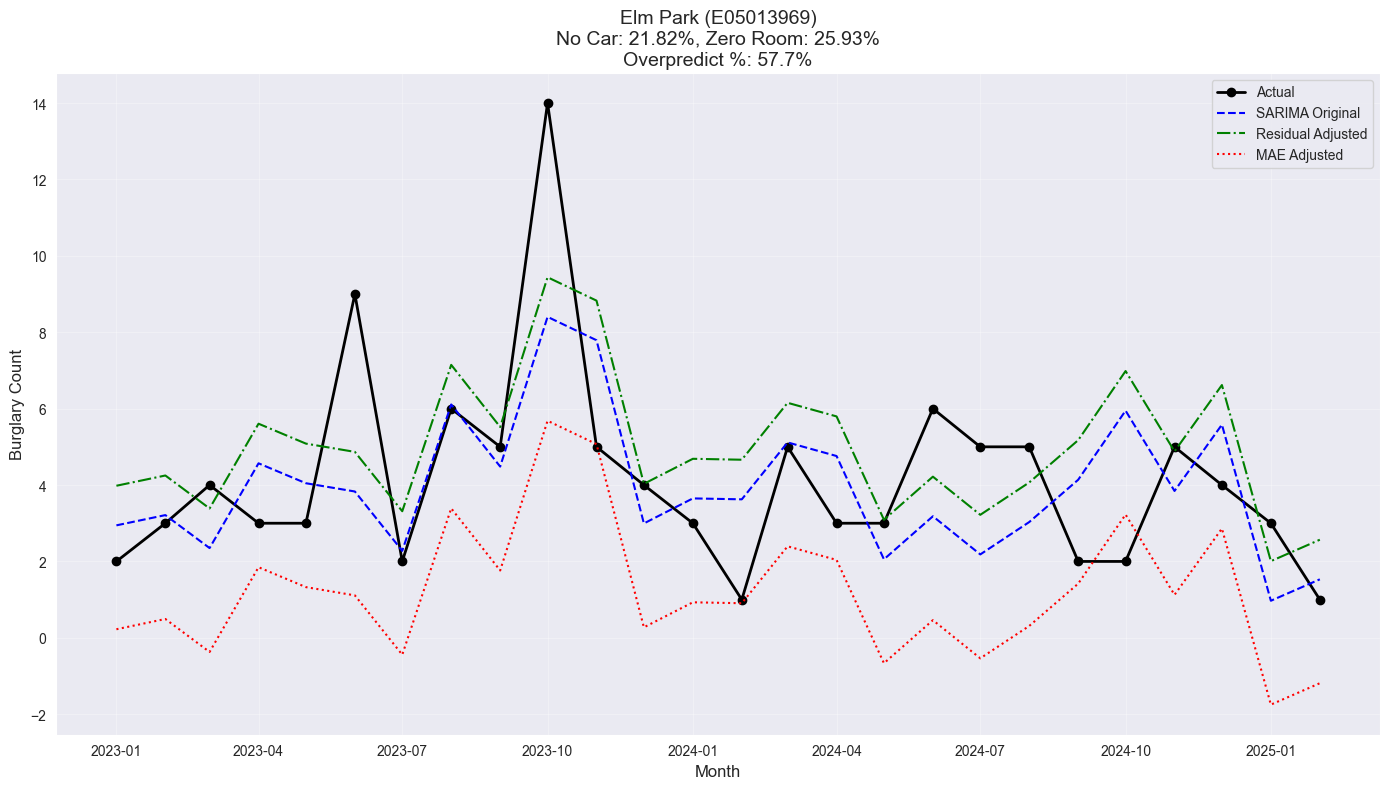


Metrics for Elm Park (E05013969):
        type      MAE     RMSE      MAPE
    Original 1.768042 2.269164 53.620723
Residual_Adj 1.976954 2.407307 71.332759
     MAE_Adj 3.026272 3.697347 77.024242




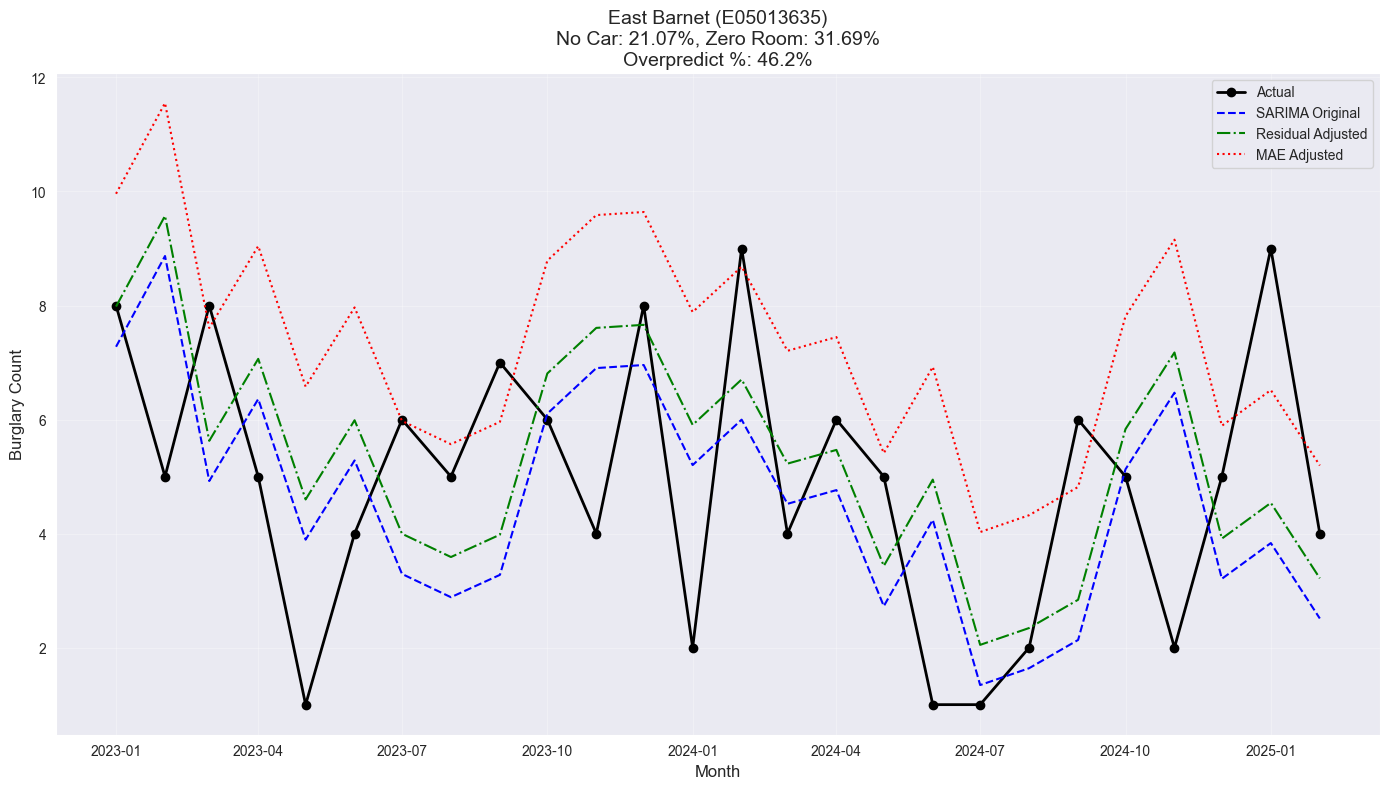


Metrics for East Barnet (E05013635):
        type      MAE     RMSE       MAPE
    Original 2.188312 2.602384  68.140562
Residual_Adj 2.160552 2.611814  77.398005
     MAE_Adj 2.784458 3.502694 117.767846




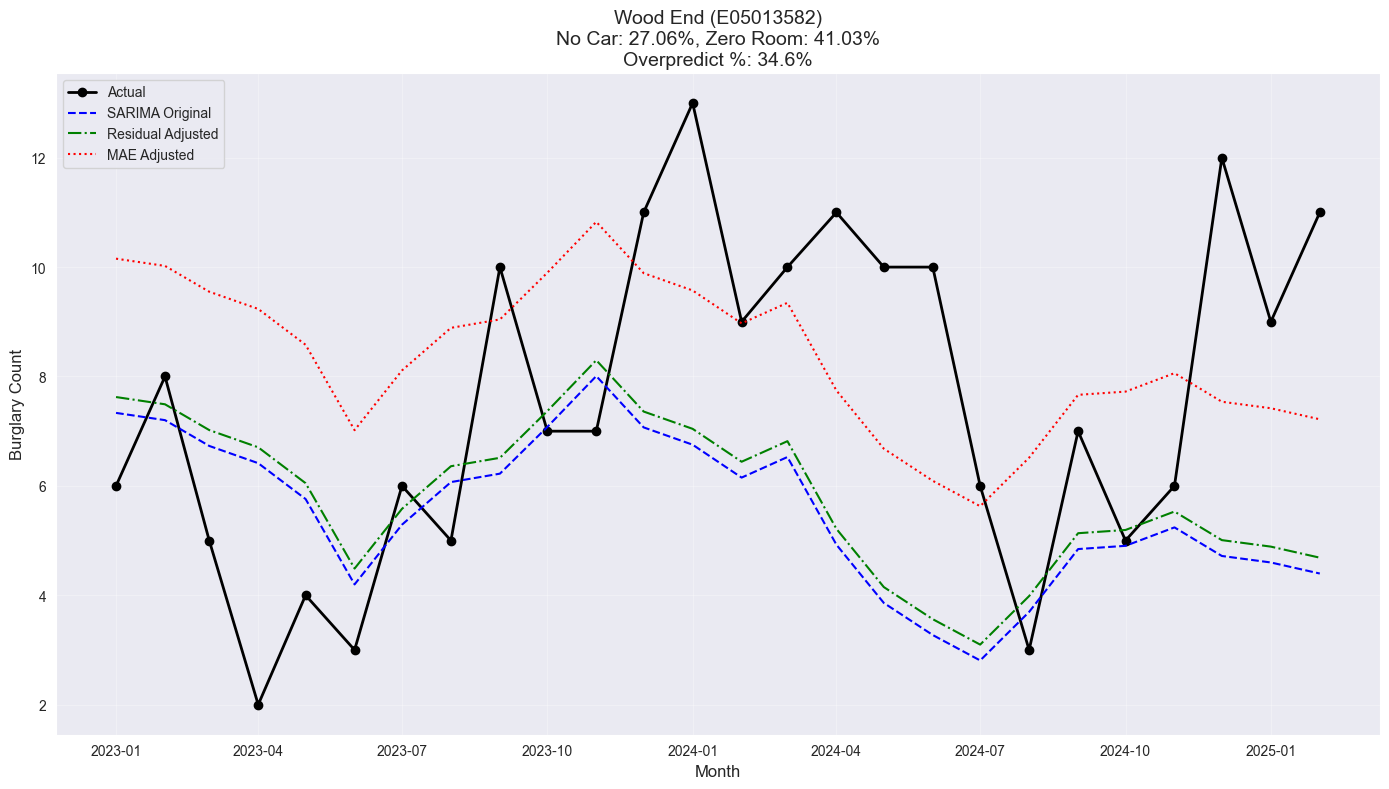


Metrics for Wood End (E05013582):
        type      MAE     RMSE      MAPE
    Original 3.019340 3.786555 41.669777
Residual_Adj 2.945038 3.641999 42.241684
     MAE_Adj 2.888614 3.320446 56.548634




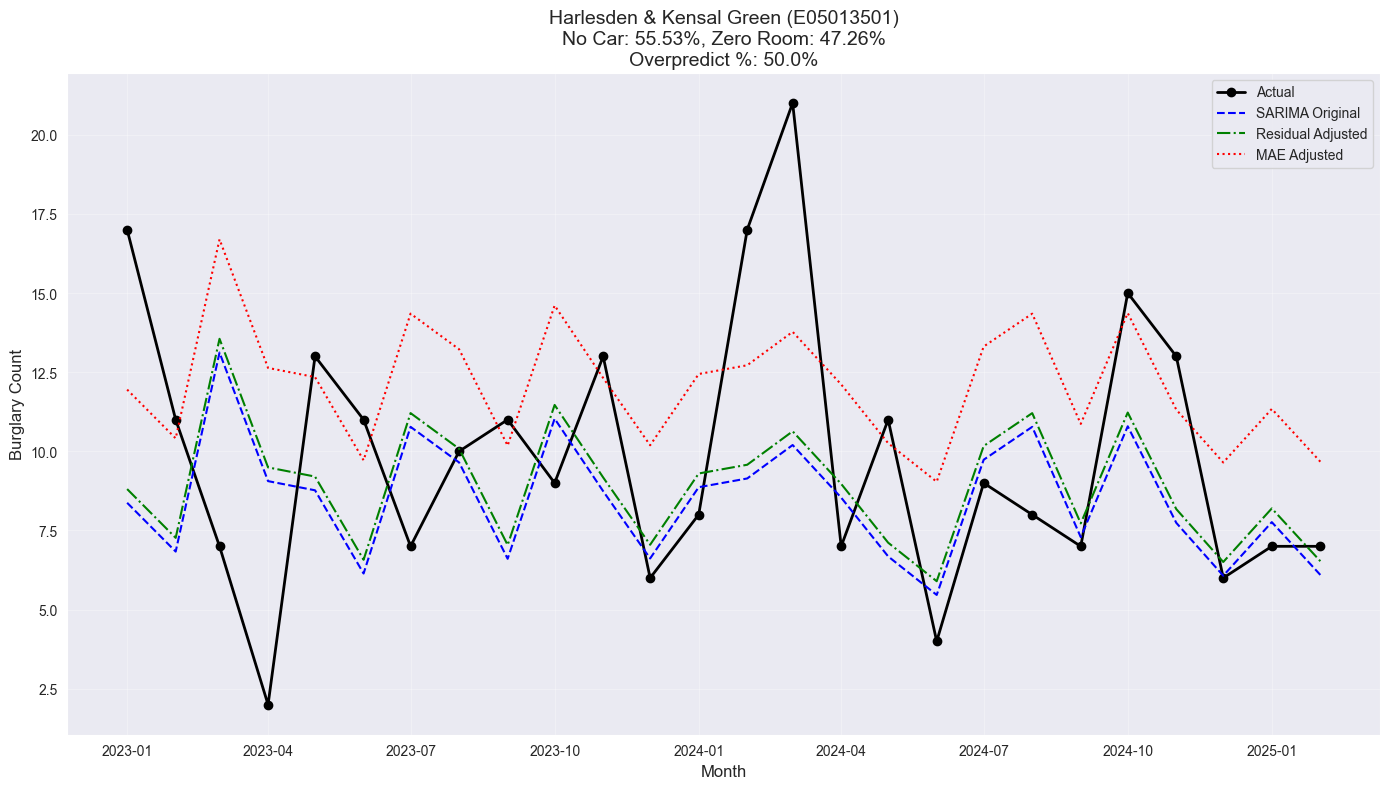


Metrics for Harlesden & Kensal Green (E05013501):
        type      MAE     RMSE      MAPE
    Original 3.551354 4.532959 42.903220
Residual_Adj 3.557625 4.419372 44.967675
     MAE_Adj 4.004846 4.836613 64.828483




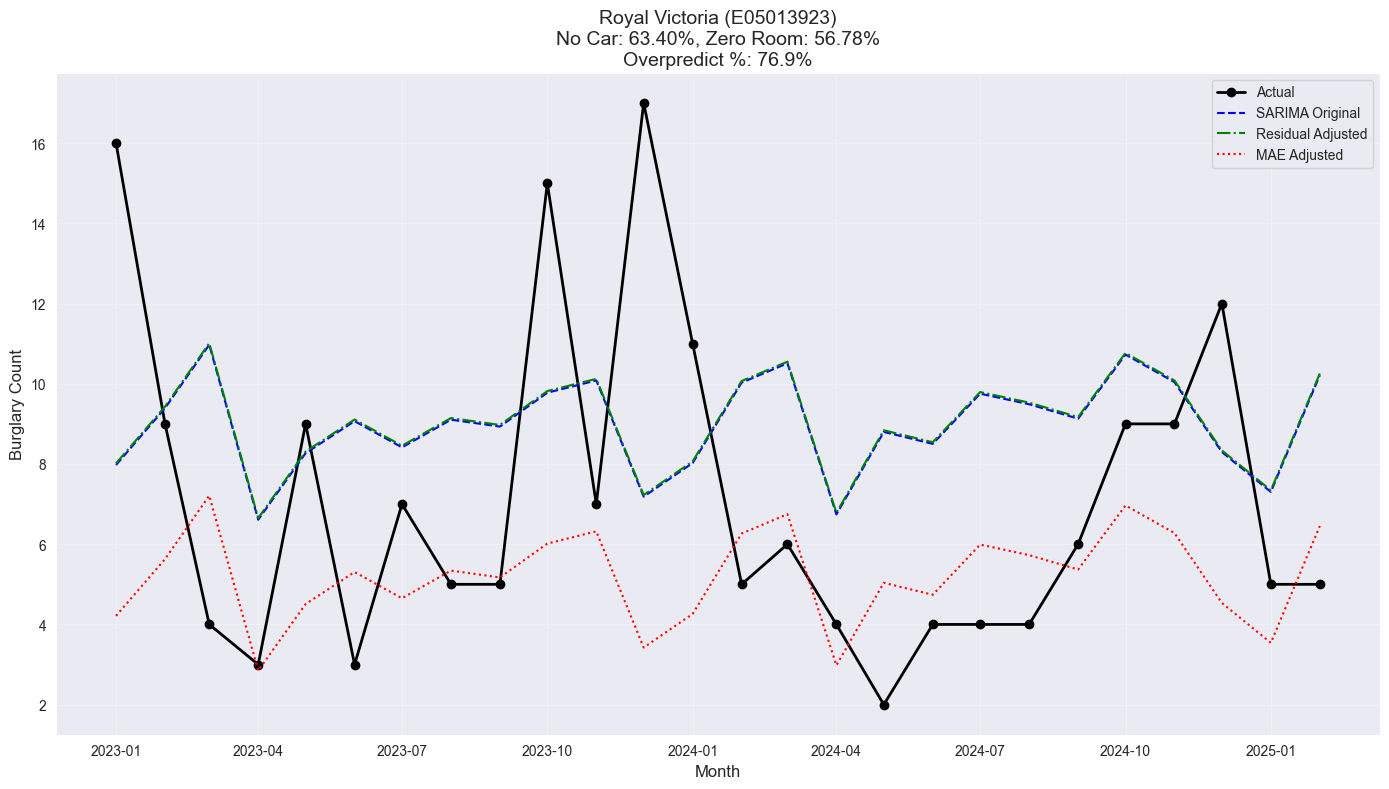


Metrics for Royal Victoria (E05013923):
        type      MAE     RMSE      MAPE
    Original 4.164958 4.734399 82.547124
Residual_Adj 4.186787 4.750141 83.154541
     MAE_Adj 3.247993 4.781617 41.851896




In [24]:

# 4. Visualize results for sample wards
sample_wards = hybrid_data.sample(5, random_state=42)['ward_code'].tolist()
n_months = TEST_MONTHS

for i, ward_code in enumerate(sample_wards):
    ward_data = hybrid_data[hybrid_data['ward_code'] == ward_code].iloc[0]

    # Generate a monthly date range starting at 2023-01-01 for TEST_MONTHS months.
    start_date = pd.to_datetime("2023-01-01")
    months = pd.date_range(start=start_date, periods=n_months, freq='MS')

    plt.figure(figsize=(14, 8))
    # Plot actual values
    plt.plot(months, ward_data['actual'], 'ko-', label='Actual', linewidth=2)

    # Plot original predictions
    plt.plot(months, ward_data['predicted'], 'b--', label='SARIMA Original')

    # Plot adjusted predictions
    plt.plot(months, ward_data['adj_res_pred'], 'g-.', label='Residual Adjusted')
    plt.plot(months, ward_data['adj_mae_pred'], 'r:', label='MAE Adjusted')

    # Add ward info to title
    ward_name = burglary[burglary['Ward Code'] == ward_code]['Ward name'].iloc[0]
    title = f"{ward_name} ({ward_code})\n"
    title += f"No Car: {ward_data['NoCarPct']:.2%}, "
    title += f"Zero Room: {ward_data['ZeroRoomPct']:.2%}\n"
    title += f"Overpredict %: {ward_data['overpredict_pct']:.1f}%"

    plt.title(title, fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Burglary Count', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print metrics for this ward
    ward_metrics = metrics_df[metrics_df['ward'] == ward_code]
    print(f"\nMetrics for {ward_name} ({ward_code}):")
    print(ward_metrics[['type', 'MAE', 'RMSE', 'MAPE']].to_string(index=False))
    print("\n" + "="*80 + "\n")